## 初始化数据集

In [38]:
from paddle.vision import Normalize
from dataset import MyDataset
# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 打印数据集样本数
train_dataset = MyDataset(mode='train', transform=transform)
test_dataset = MyDataset(mode='test', transform=transform)
print('train_dataset images: ',len(train_dataset), 'test__dataset images: ',len(test_dataset))

Initializing dataset: 100%|██████████| 10000/10000 [00:01<00:00, 5311.81it/s]

train_custom_dataset images:  120000 test_custom_dataset images:  20000


绘制数据集前50张图

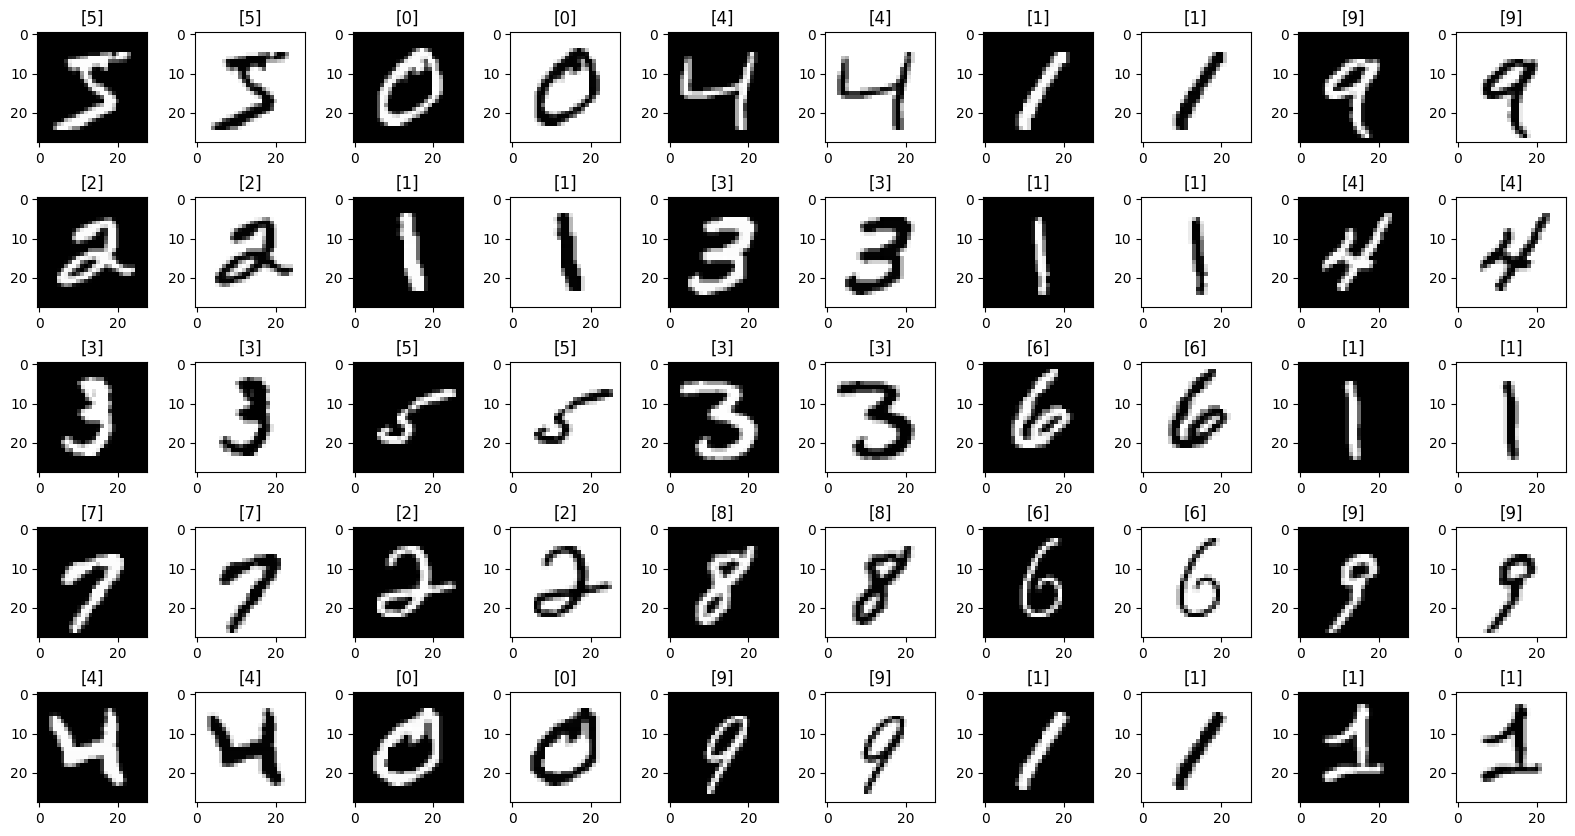

In [39]:
import itertools
import matplotlib
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
for i, item in enumerate(itertools.islice(train_dataset, 0, 50)):
    # print(img, label)
    plt.subplot(5, 10, i+1)
    image, label = item
    plt.title(str(label))
    plt.imshow(image.squeeze(0), cmap=matplotlib.cm.gist_gray)

plt.subplots_adjust(hspace=0.5)
plt.show()

## 训练模型

### 1. LeNet

![LeNet-5](./assets/LeNet-5.png)



In [42]:
from models.LeNet import LeNet
import paddle
import numpy as np

BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 20

network = LeNet()
model = paddle.Model(network)
def train_model():
    model.prepare(paddle.optimizer.Adam(learning_rate=LEARNING_RATE, parameters=model.parameters()),
                  paddle.nn.CrossEntropyLoss(),
                  paddle.metric.Accuracy())
    # 模型训练
    model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    # 保存模型
    model.save('./output/LeNet-Adam-CrossEntropyLoss')

train_model()
# 加载模型
# model.load('output/LeNet-Adam-CrossEntropyLoss')

# 模型评估
model.prepare()
model.evaluate(test_dataset, batch_size=BATCH_SIZE, verbose=1)

# 从测试集中取出一张图片
img, label = test_dataset[0]
# 将图片shape从1*28*28变为1*1*28*28，增加一个batch维度，以匹配模型输入格式要求
img_batch = np.expand_dims(img.astype('float32'), axis=0)

# 执行推理并打印结果，此处predict_batch返回的是一个list，取出其中数据获得预测结果
out = model.predict_batch(img_batch)[0]
pred_label = out.argmax()
print(f'true label: {label[0]}, pred label: {pred_label}')
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0])

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/20
step  120/1875 [>.............................] - loss: 0.3088 - acc: 0.7267 - ETA: 50s - 29ms/step

KeyboardInterrupt: 

In [36]:
import os
import random

import numpy as np
# 加载飞桨相关库
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 加载visualdl
from visualdl import LogWriter

logwriter = LogWriter(logdir='./runs/mnist_experiment')


train_loader = paddle.io.DataLoader(train_dataset,
                                    batch_size=16,
                                    shuffle=True)

test_loader = paddle.io.DataLoader(test_dataset,
                                   batch_size=16,
                                   shuffle=False)

# 定义mnist数据识别网络模型结构
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()

        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是10
        self.fc = Linear(in_features=980, out_features=10)

    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc(x)
        return x

from models.LeNet import LeNet

#创建模型
model = LeNet()
# model = MNIST()

#保存动态图模型为静态图
paddle.jit.save(model, './runs/mnist_experiment/model', [paddle.static.InputSpec([-1,1,28,28])])

#设置优化器
opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
EPOCH_NUM = 10

logwriter.add_hparams(hparams_dict={'lr': 0.001, 'batch_size': 16, 'opt': 'sgd'},
                      metrics_list=['train_avg_loss', 'test_avg_loss', 'test_avg_acc'])

for epoch_id in range(EPOCH_NUM):
    model.train()
    train_batchs_per_epoch = len(train_loader)
    for batch_id, data in enumerate(train_loader):
        #准备数据
        images, labels = data

        #前向计算的过程
        predicts = model(images)

        #计算损失，取一个批次样本损失的平均值
        loss = F.cross_entropy(predicts, labels)
        avg_loss = paddle.mean(loss)

        #记录当前训练Loss到VisualDL
        logwriter.add_scalar("train_avg_loss", value=avg_loss.numpy(), step=batch_id+epoch_id*(train_batchs_per_epoch))

        #记录网络中最后一个fc层的参数到VisualDL
        logwriter.add_histogram("fc_weight", values=model.fc.weight.numpy(), step=batch_id+epoch_id*(train_batchs_per_epoch))

        #每训练了100批次的数据，打印下当前Loss的情况
        if batch_id % 200 == 0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))

        #后向传播，更新参数的过程
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

    # evaluate model after one epoch
    model.eval()
    accuracies = []
    losses = []
    class_probs = []
    class_preds = []
    for batch_id, data in enumerate(test_loader):
        #准备数据
        images, labels = data
        #前向计算的过程
        predicts = model(images)
        #计算损失
        loss = F.cross_entropy(predicts, labels)
        #计算准确率
        acc = paddle.metric.accuracy(predicts, labels)
        accuracies.append(acc.numpy())
        losses.append(loss.numpy())
        #记录用于画pr曲线需要的预测概率和类别
        class_probs_batch = [F.softmax(predict, axis=0) for predict in predicts]
        class_preds_batch = paddle.argmax(predicts, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

    test_probs = paddle.concat([paddle.stack(batch) for batch in class_probs]).numpy()
    test_preds = paddle.concat(class_preds).numpy()

    for i in range(10):
        logwriter.add_pr_curve('class_{}'.format(i), labels=(test_preds == i),predictions=test_probs[:,i], num_thresholds=100, step=epoch_id)

    avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
    print("[validation]After epoch {}: accuracy/loss: {}/{}".format(epoch_id, avg_acc, avg_loss))
    #记录当前测试集平均Loss和准确率到VisualDL
    logwriter.add_scalar("test_avg_loss", value=avg_loss, step=epoch_id)
    logwriter.add_scalar("test_avg_acc", value=avg_acc, step=epoch_id)

#保存模型参数
paddle.save(model.state_dict(), 'mnist.pdparams')

ValueError: Function: forward doesn't exist in the Module transformed from AST.